In [1]:
from gorani.booky.book import Book, read_epub

In [2]:
from metaflow import Flow

In [3]:
run = Flow('MergeFilterPaginate').latest_successful_run

In [4]:
df = run.data.pages

In [5]:
import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette("RdBu_r", 7))

In [6]:
eltimes = df.copy()
eltimes['count'] = 1
eltimes = eltimes.groupby('userId').sum()
eltimes = eltimes[['eltime', 'count']]

In [7]:
eltimes['cheat'] = eltimes['eltime'].map(lambda x: x <= 665)

In [8]:
df = run.data.pages
df = df.sort_values(['time'])

In [9]:
import numpy as np
import pandas as pd

In [10]:
df = df.set_index('userId').join(eltimes[['cheat']])

In [11]:
df['i'] = np.arange(len(df))
df['signalWord'] = df.apply(lambda x: [[x['words'][i].lower(), 0 if (i in x['unknownIndices']) or (x['words'][i].lower() in [y.lower() for y in x['unknownWords']]) else 1] for i in range(len(x['words']))], axis = 1)

In [133]:
def handle(value):
    words = []
    knows = []
    times = []
    for x, t in zip(value['signalWord'], value['time']):
        for y in x:
            if len(y) != 2:
                continue    
            words.append(y[0])
            knows.append(y[1])
            times.append(t)
    return pd.DataFrame({'word': words, 'known': knows, 'time': times}).reset_index()
df3 = df.groupby(['userId', 'cheat']).apply(handle).reset_index(level=2, drop=True).reset_index()
df3.set_index(['userId', 'cheat', 'word'], inplace=True)
df3 = df3.sort_values(['time'])

In [217]:
def retention(df):
    count = 0
    start = 0
    total = 0
    days = []
    maxDay = 0
    
    for t, k in zip(df['time'], df['known']):
        if start == 0:
            start = t
        dur = t - start
        total += k
        count += 1
        tmp = int(dur/(60*60))
        days.append({'day': tmp, 'known': k})
        if maxDay < tmp:
            maxDay = tmp
    df = pd.DataFrame(days).groupby('day').mean().reset_index()
    if df.size >=2:
        first = df.iloc[0]['known']
        last = df.iloc[-1]['known']
    else:
        first = np.nan
        last = np.nan
    df = df[['day','known']].T.to_dict().values()
    return pd.Series({'count': count, 'days': maxDay + 1, 'avg': total/count, 'first': first, 'last': last, 'df': df})

df4 = df3.groupby(['userId','cheat', 'word']).apply(retention)

In [218]:
df4['known'] = df4['df'].map(lambda x: [y['known'] for y in x])
df4['day'] = df4['df'].map(lambda x: [y['day'] for y in x])

In [219]:
def unnesting(df, explode, axis):
    if axis==1:
        idx = df.index.repeat(df[explode[0]].str.len())
        df1 = pd.concat([
            pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
        df1.index = idx

        return df1.join(df.drop(explode, 1), how='left')
    else :
        df1 = pd.concat([
                         pd.DataFrame(df[x].tolist(), index=df.index).add_prefix(x) for x in explode], axis=1)
        return df1.join(df.drop(explode, 1), how='left')

In [220]:
df5 = unnesting(df4[['known','day','first', 'count']],['known','day'], axis=1)
df6 = df5.query('cheat != True and count < 20')

In [ ]:


km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5,
                      random_state=0).fit(X)


In [250]:

def parallel_coordinates(frame, value_column, class_column, x_column, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from scipy.interpolate import splrep, splev, interp1d
    n = len(frame)
    
    if isinstance(class_column, list):
        frame['class'] = frame.apply(lambda x: '*'.join([x[cla] for cla in class_column]), axis=1)
        frame['class'], uniques = pd.factorize(frame['class'], sort=True)
        class_col = frame['class']
        class_column = 'class'
    else:
        frame[class_column], uniques = pd.factorize(frame[class_column], sort=True)
        class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)
    
    value_col = frame[value_column]
    value_min = np.amin(value_col)
    value_max = np.amax(value_col)
    
    x_col = frame[x_column]
    x_min = np.amin(x_col)
    x_max = np.amax(x_col)

    used_legends = set([])

    fig = plt.figure()
    ax = plt.gca()

    Colorm = plt.get_cmap(colormap)

    for i in range(class_max):
        df = frame.loc[frame[class_column] == i].sort_values([x_column])
        x = df[x_column].reset_index(drop=True)
        y = df[value_column].reset_index(drop=True)
        if x.size <= 2:
            pass
        elif y[x.size-1] > 0.5:
            ax.plot(x, y, color='green', alpha=0.1)
        else:
            ax.plot(x, y, color='red', alpha=0.1)  
    
    ax.legend(loc='upper right')
    ax.grid()
    
    return fig

No handles with labels found to put in legend.


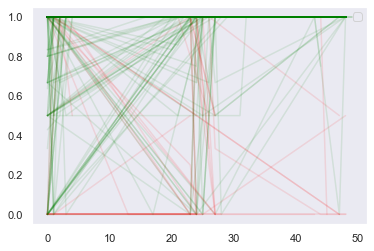

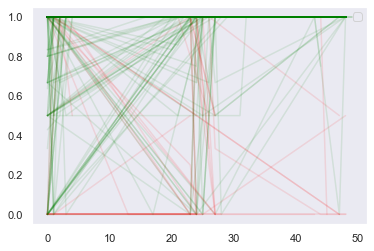

In [251]:
parallel_coordinates(df6.query('day < 50').reset_index(), 'known', ['word', 'userId'], 'day')